In [26]:
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as patheffects

def get_results_mean(ontology_name, reasoner, metrics_index):
    tasks = ["Membership", "Link Prediction"]
    file_pattern = f"models/results/{reasoner}/{ontology_name}*.txt"  

    data = []

    for filepath in glob.glob(file_pattern, recursive=True):
        filename = filepath.split("\\")[-1] 
        parts = filename.replace(".txt", "").split("_")
        reasoner = f"{reasoner}"

        if len(parts) == 1:  
            ontology = f"{ontology_name}"
            noise_type = "None"
            noise_level = 0
        elif len(parts) == 3: 
            ontology, noise_type, noise_level = parts
        else:
            print(f"⚠️ Skipping file (unexpected filename): {filename}")
            continue

        with open(filepath, "r", encoding="utf-8") as f:
            lines = f.readlines()

        current_task = None
        for line in lines:
            line = line.strip()
            if line.rstrip(":") in tasks:
                current_task = line.rstrip(":")
            elif line.startswith("Mean:") and current_task:
                mean_values = line.replace("Mean:", "").split("&")
                mean_values = [float(x.strip()) for x in mean_values if x.strip()]
                if len(mean_values) > metrics_index:
                    mrr = mean_values[metrics_index]
                    data.append({
                        "Ontology": ontology,
                        "Reasoner": reasoner,
                        "NoiseType": noise_type,
                        "NoiseLevel": noise_level,
                        "Task": current_task,
                        "MRR": mrr
                    })
                current_task = None

    df = pd.DataFrame(data)
    return df

def visualize(df, noise_type, title, output_file_name):

    sns.set_theme(style="whitegrid", font_scale=1.3)

    # Filter data
    df_noise_type = df[df['NoiseType'] == noise_type].copy()
    df_noise_type['NoiseLevel'] = pd.to_numeric(df_noise_type['NoiseLevel'], errors='coerce')
    df_noise_type['MRR'] = pd.to_numeric(df_noise_type['MRR'], errors='coerce')
    df_noise_type = df_noise_type.dropna(subset=['NoiseLevel', 'MRR'])
    df_owl2vec = df_noise_type[df_noise_type['Reasoner'] == 'owl2vec']
    df_box2el = df_noise_type[df_noise_type['Reasoner'] == 'box2el']
    df_gnn = df_noise_type[df_noise_type['Reasoner'] == 'rgcn_reasoner']

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Helper function for line plots with value annotations
    def plot_line_with_values(ax, data, title):
        palette = sns.color_palette("Set2", n_colors=data['Task'].nunique())
        task_order = data['Task'].drop_duplicates().tolist()  # ensure consistent order
        task_color_map = {task: palette[i] for i, task in enumerate(task_order)}

        sns.lineplot(
            data=data,
            x="NoiseLevel", y="MRR", hue="Task",
            marker="o", palette="Set2", err_style="bars", errorbar="sd", ax=ax
        )
        ax.set_title(title)
        ax.set_ylim(0, 1.1)  # more room for labels
        ax.set_xlabel("Noise Level")
        ax.set_ylabel("MRR" if ax == axes[0] else "")
        ax.grid(True)

        # Set x-ticks with 0.25 spacing from min to max NoiseLevel
        min_x, max_x = data['NoiseLevel'].min(), data['NoiseLevel'].max()
        ticks = list(np.arange(min_x, max_x + 0.25, 0.25))
        ax.set_xticks(ticks)

        texts = []
        for task in data['Task'].unique():
            task_data = data[data['Task'] == task]
            label_color = task_color_map.get(task, "black")
            for _, row in task_data.iterrows():
                texts.append(
                    ax.text(
                        row['NoiseLevel'], row['MRR'] + 0.04,
                        f"{row['MRR']:.3f}",
                        color=label_color,
                        ha='center', va='bottom',
                        fontsize=12,
                        fontweight="bold",
                        path_effects=[patheffects.withStroke(linewidth=3, foreground="white")]
                    )
                )
        adjust_text(texts, ax=ax)  # no arrows this time

    # Plot each reasoner
    plot_line_with_values(axes[0], df_owl2vec, "OWL2Vec")
    plot_line_with_values(axes[1], df_box2el, "Box2EL")
    plot_line_with_values(axes[2], df_gnn, "RGCN")

    # Create a single legend on the last plot
    handles, labels = axes[2].get_legend_handles_labels()
    axes[2].legend(handles, labels, title="Task", loc='upper right')
    axes[0].legend_.remove()
    axes[1].legend_.remove()

    # Save and show the plot
    save_dir = "models/results/figures/"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, output_file_name)
    title = title.replace("Gnn", "Statistical")
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300)

def main(ontology_name, noise_type):
    df_box2el = get_results_mean(ontology_name, 'box2el', 0)
    df_owl2vec = get_results_mean(ontology_name, 'owl2vec', 0)
    df_gnn = get_results_mean(ontology_name, 'rgcn_reasoner', 0)
    df = pd.concat([df_box2el, df_owl2vec, df_gnn], ignore_index=True)

    noise_types = ['random', 'logical', 'gnn']
    dfs = [df[df['NoiseType'] == 'None'].assign(NoiseType=noise) for noise in noise_types]
    df_no_noise = pd.concat(dfs, ignore_index=True)
    df = pd.concat([df, df_no_noise], ignore_index=True)

    visualize(df, noise_type, f'{noise_type.capitalize()} Noise - {ontology_name.capitalize()}', f'{ontology_name}_{noise_type}')

In [ ]:
main('family', 'random')
main('family', 'gnn')
main('family', 'logical')

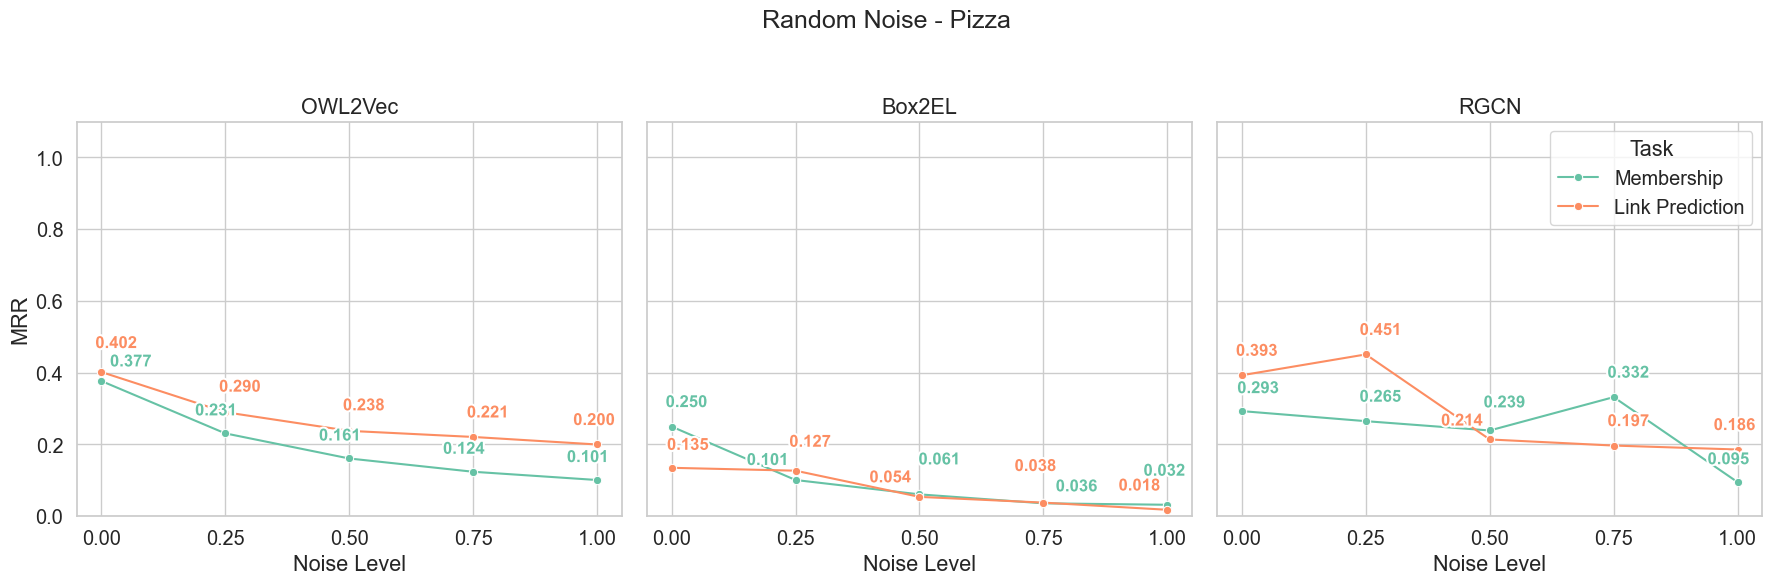

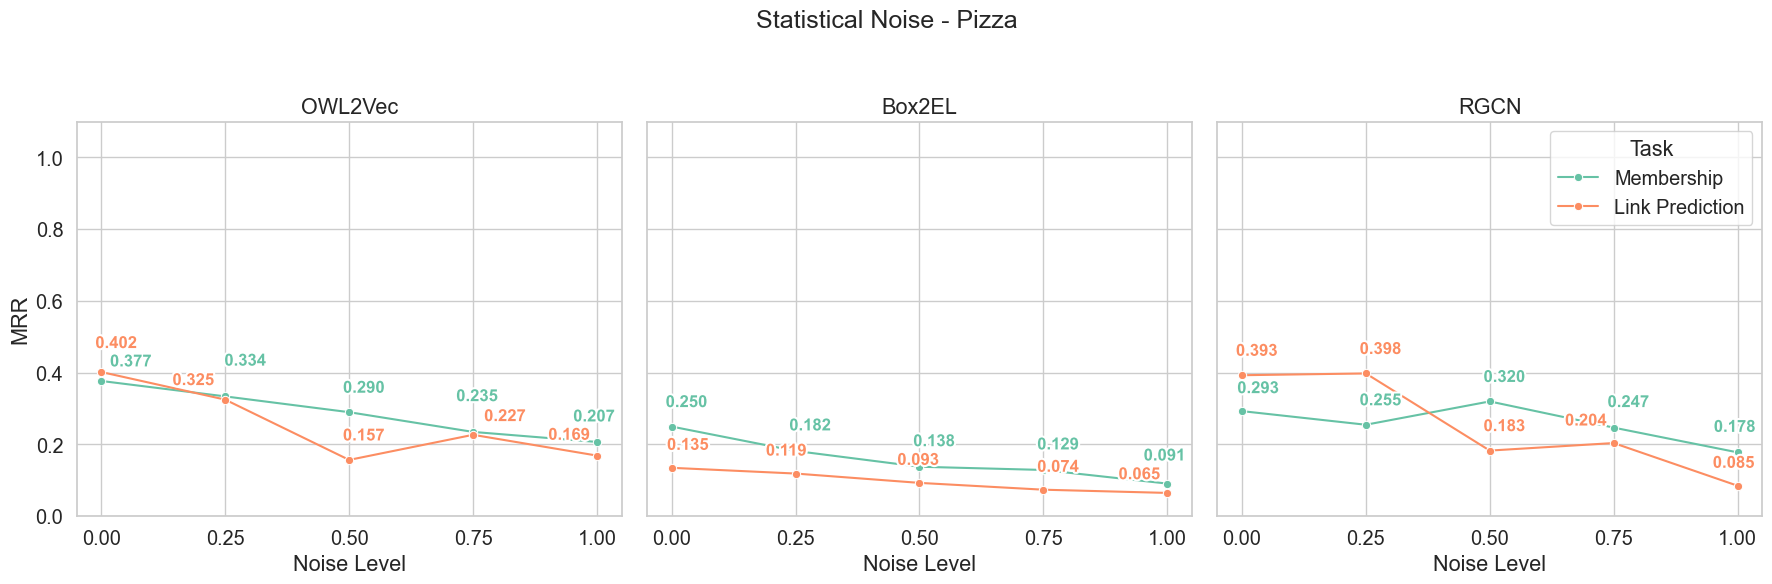

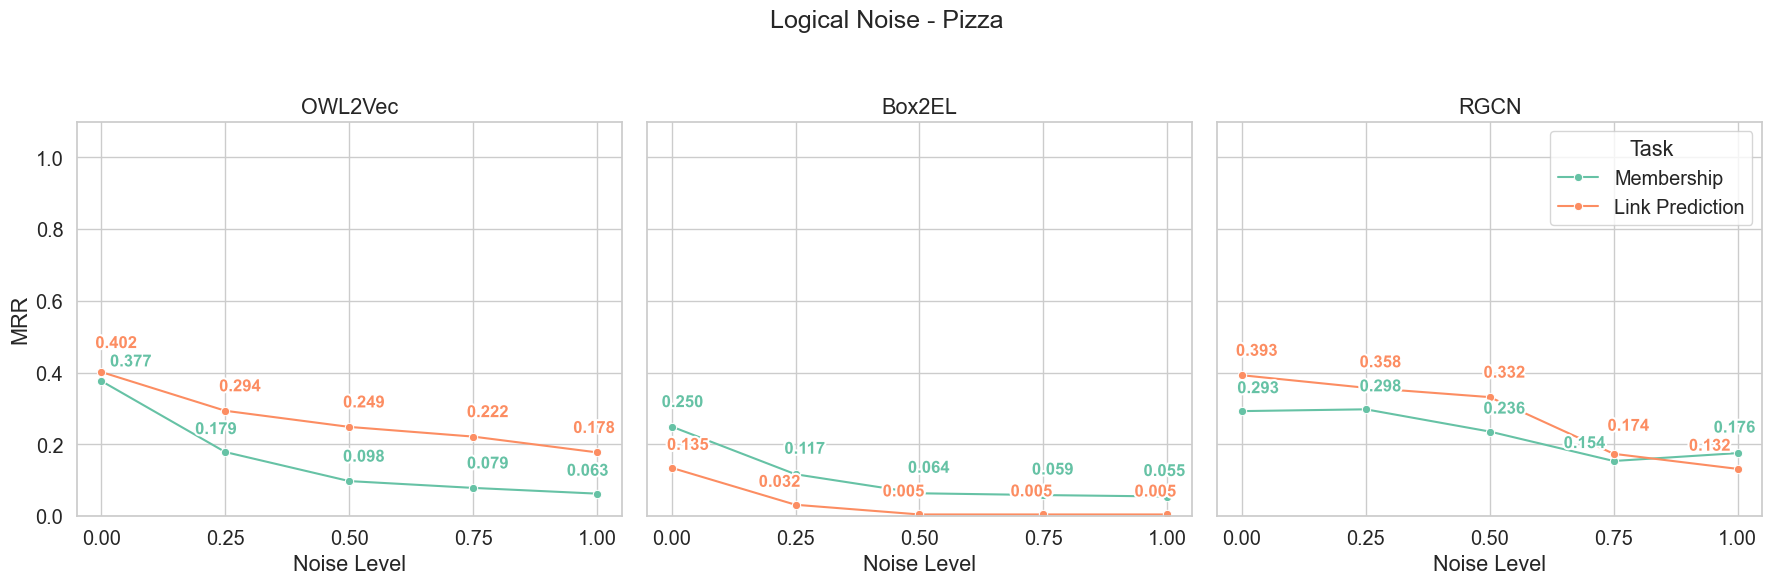

In [31]:
main('pizza', 'random')
main('pizza', 'gnn')
main('pizza', 'logical')